# D.3. Classic MV Optimization

## Module: Risk

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

# Import Packages, Settings

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns
#import statsmodels.api as sm

In [3]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

# Import and Organize Data
### Data Source: Yahoo Finance

In [4]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [5]:
info

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


In [6]:
retsx

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0448,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0045,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.0519,-0.0355,0.0006,-0.0852,-0.0199,-0.0257,0.0797,-0.0815,-0.0203,-0.0254,-0.0198
2022-02-28,-0.0292,-0.0339,-0.0428,-0.0732,-0.0064,-0.0082,0.0650,-0.0455,-0.0027,-0.0108,0.0089
2022-03-31,0.0380,0.0056,-0.0334,-0.0074,-0.0022,-0.0125,0.0921,0.0690,-0.0402,-0.0419,-0.0184


# Performance Metrics

In [7]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1460,0.1432,1.0195,-0.1290,0.1268
IYR,0.1479,0.1843,0.8023,-0.2005,0.2956
HYG,0.0685,0.0860,0.7970,-0.1044,0.1379
TIP,0.0313,0.0456,0.6854,-0.0418,0.0396
PSP,0.1347,0.2177,0.6184,-0.2789,0.2296
EFA,0.0825,0.1604,0.5139,-0.1452,0.1429
QAI,0.0195,0.0486,0.4010,-0.0605,0.0340
IEF,0.0231,0.0586,0.3947,-0.0440,0.0461
EEM,0.0721,0.1934,0.3731,-0.1791,0.1628
DBC,0.0394,0.1807,0.2180,-0.1776,0.1631


MIN Correlation pair is ('IEF', 'DBC')
MAX Correlation pair is ('EFA', 'PSP')


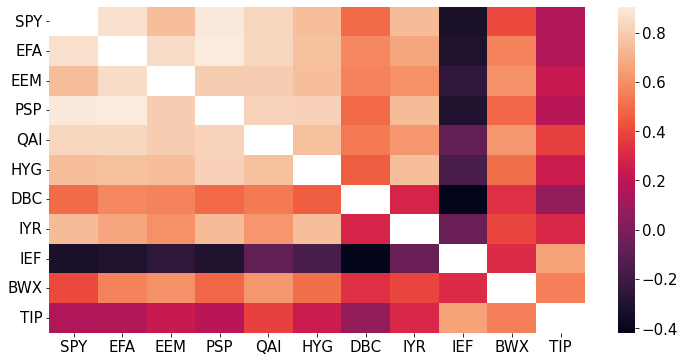

In [8]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. Furthermore, they have outperformed Domestic bonds in terms of mean and in terms of volatility.

Notably, TIPS have very low correlation to the other assets--including relatively low coorrelation to IEF (Domestic Bonds). In the correlation heat map above, we see that TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

## The Tangency and the MV Frontier

In [9]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])

performanceMetrics(pd.concat([retsx,retsx_tan],axis=1),annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1460,0.1432,1.0195,-0.1290,0.1268
EFA,0.0825,0.1604,0.5139,-0.1452,0.1429
EEM,0.0721,0.1934,0.3731,-0.1791,0.1628
PSP,0.1347,0.2177,0.6184,-0.2789,0.2296
QAI,0.0195,0.0486,0.4010,-0.0605,0.0340
HYG,0.0685,0.0860,0.7970,-0.1044,0.1379
DBC,0.0394,0.1807,0.2180,-0.1776,0.1631
IYR,0.1479,0.1843,0.8023,-0.2005,0.2956
IEF,0.0231,0.0586,0.3947,-0.0440,0.0461
BWX,0.0056,0.0765,0.0733,-0.0694,0.0612


## Not Required - For Illustration

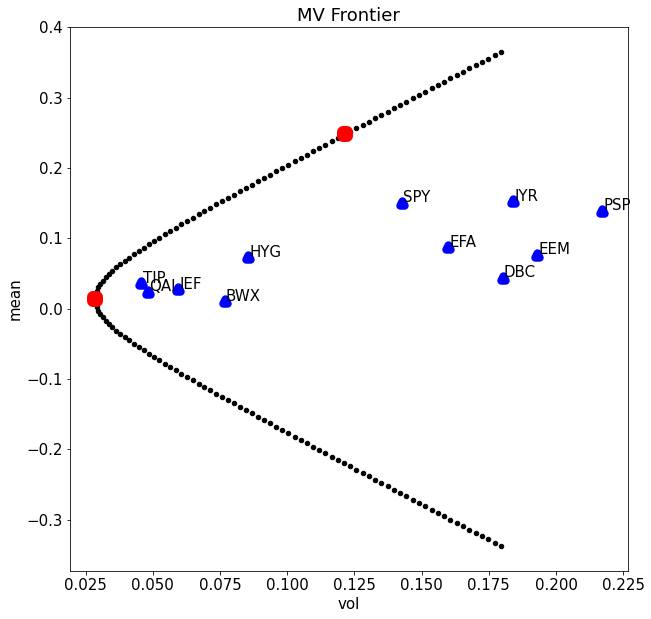

In [10]:
omega_tan = tangency_weights(rets)
rets_adj = rets - rets.mean() + 1
omega_gmv = tangency_weights(rets_adj)
omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-1.5,1.5,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = rets @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=rets.index)
rets_special['tan'] = rets @ omega_tan.values
rets_special['gmv'] = rets @ omega_gmv.values

mv_assets = pd.concat([rets.mean() * 12,rets.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

### How similar are tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [11]:
comp = pd.concat([wts['tangency'], omega['tangency']],axis=1)
comp.columns = ['tan.riskfree','tan.zero']
comp

print(f'Correlation between tangency weights in total and excess returns is {comp.corr().values[0,1]:.4f}.')

Correlation between tangency weights in total and excess returns is 0.9984.


## The Allocation

In [12]:
target_mean = .01

mu_tan = retsx.mean() @ wts['tangency']
delta = target_mean / mu_tan

wts['optimal'] = wts['tangency'] * delta

# list the assets sharpe ratios in a column to demonstrate not highly correlated with optimal weights
comp = pd.concat([wts[['optimal']],mets['Sharpe']],axis=1)
corr_sharpe_wts = comp.corr().values[0][1]

comp.sort_values('optimal',ascending=False)

,optimal,Sharpe
IEF,0.8836,0.3947
SPY,0.8477,1.0195
HYG,0.4748,0.7970
TIP,0.2727,0.6854
DBC,0.0842,0.2180
EEM,0.0523,0.3731
EFA,0.0184,0.5139
PSP,-0.1302,0.6184
IYR,-0.1478,0.8023
BWX,-0.3669,0.0733


In [13]:
print(f'Total share in risky assets is {delta:.4f}.\nTotal share in risk-free asset is {1-delta:.4f}')
print(f'Correlation between an assets Sharpe ratio and its weight is {corr_sharpe_wts:.4f}.')

Total share in risky assets is 0.3257.
Total share in risk-free asset is 0.6743
Correlation between an assets Sharpe ratio and its weight is 0.3938.


## Simple Portfolios

In [14]:
wts['equal'] = 1/len(retsx.columns)
wts['parity'] = 1/retsx.std()
# rescale these to hit the target mean
wts[['equal','parity']] *= target_mean / (retsx.mean()@wts[['equal','parity']])

wts

,tangency,optimal,equal,parity
SPY,2.6028,0.8477,0.1557,0.1421
EFA,0.0565,0.0184,0.1557,0.1268
EEM,0.1606,0.0523,0.1557,0.1052
PSP,-0.3998,-0.1302,0.1557,0.0935
QAI,-5.1064,-1.6631,0.1557,0.4184
HYG,1.4578,0.4748,0.1557,0.2368
DBC,0.2585,0.0842,0.1557,0.1127
IYR,-0.4537,-0.1478,0.1557,0.1104
IEF,2.7129,0.8836,0.1557,0.3476
BWX,-1.1265,-0.3669,0.1557,0.2662


In [15]:
mets_full = performanceMetrics(retsx @ wts,annualization=12)
mets_full

,Mean,Vol,Sharpe,Min,Max
tangency,0.3684,0.1836,2.0068,-0.1031,0.1743
optimal,0.1200,0.0598,2.0068,-0.0336,0.0568
equal,0.1200,0.1689,0.7106,-0.2006,0.1580
parity,0.1200,0.1587,0.7559,-0.1813,0.1251


## For Illustration, not Required

### Suppose TIPS had a mean return 1% (annualized) higher than in the sample

* Would the weights change much?
* Would the MV frontier change much?

In [16]:
retsx_adj = retsx.copy()
retsx_adj['TIP'] += .01/12

wts_adj = wts[['tangency','optimal']].copy()
wts_adj['tangency adj'] = tangency_weights(retsx_adj)
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])

mu_adj = retsx_adj.mean()
mu_tan_adj = mu_adj @ wts_adj['tangency adj']
delta_adj = target_mean / mu_tan

wts_adj['optimal adj'] = wts_adj['tangency adj'] * delta_adj

wts_adj

,tangency,optimal,tangency adj,optimal adj
SPY,2.6028,0.8477,2.1314,0.6942
EFA,0.0565,0.0184,0.1445,0.0471
EEM,0.1606,0.0523,0.0834,0.0272
PSP,-0.3998,-0.1302,-0.3823,-0.1245
QAI,-5.1064,-1.6631,-4.3850,-1.4282
HYG,1.4578,0.4748,1.2772,0.4160
DBC,0.2585,0.0842,0.1376,0.0448
IYR,-0.4537,-0.1478,-0.4134,-0.1346
IEF,2.7129,0.8836,1.5332,0.4994
BWX,-1.1265,-0.3669,-0.9743,-0.3173


In [17]:
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj','optimal adj']], annualization=12)
pd.concat([mets_full.loc[['tangency','optimal']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,0.3684,0.1836,2.0068,-0.1031,0.1743
optimal,0.1200,0.0598,2.0068,-0.0336,0.0568
tangency adj,0.3302,0.1581,2.0888,-0.0714,0.1623
optimal adj,0.1075,0.0515,2.0888,-0.0233,0.0529


In [18]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.4f}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.4f}')

Standard error of mean of TIPS is equal to 0.0010
Proposed adjustment to mean of TIPS is  0.0008


## Out-of-Sample Testing

In [19]:
t1 = '2020'
t2 = '2021'
retsx_IS = retsx.loc[:t1]
retsx_OOS = retsx.loc[t2:]
wts_IS = tangency_weights(retsx.loc[:t1])
wts_IS.columns = ['mv']

wts_IS['equal'] = 1/len(retsx_IS.columns)
wts_IS['parity'] = 1/retsx_IS.std()
# rescale these to hit the target mean
wts_IS *= target_mean / (retsx_IS.mean()@ wts_IS)

wts_IS

,mv,equal,parity
SPY,0.7854,0.1397,0.1215
EFA,-0.0762,0.1397,0.1043
EEM,0.0271,0.1397,0.0860
PSP,-0.0248,0.1397,0.0791
QAI,-1.1978,0.1397,0.3516
HYG,0.4614,0.1397,0.1953
DBC,-0.0708,0.1397,0.0972
IYR,-0.2090,0.1397,0.0940
IEF,0.8448,0.1397,0.3024
BWX,-0.0390,0.1397,0.2304


In [20]:
port_IS = retsx_IS @ wts_IS

performanceMetrics(port_IS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.1200,0.0524,2.2899,-0.0187,0.0654
equal,0.1200,0.1545,0.7769,-0.1800,0.1417
parity,0.1200,0.1345,0.8922,-0.1525,0.1043


In [21]:
port_OOS = retsx_OOS @ wts_IS

performanceMetrics(port_OOS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,-0.0411,0.0930,-0.4421,-0.0711,0.0311
equal,0.0056,0.1248,0.0446,-0.0745,0.0534
parity,-0.0534,0.1215,-0.4396,-0.0878,0.0474


### Why does the MV Portfolio do worse?
#### It has a huge position in SPY, and SPY was the best performing asset in 2021!

In [22]:
performanceMetrics(retsx_OOS,annualization=12).sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
DBC,0.4763,0.1610,2.9578,-0.0871,0.1014
IYR,0.1119,0.1983,0.5641,-0.0861,0.0944
SPY,0.0539,0.1559,0.3459,-0.0875,0.0704
TIP,-0.0050,0.0483,-0.1033,-0.0215,0.0268
EFA,-0.0212,0.1121,-0.1893,-0.0671,0.0436
PSP,-0.0746,0.2122,-0.3515,-0.1254,0.0951
HYG,-0.0513,0.0542,-0.9462,-0.0415,0.0226
EEM,-0.1395,0.1053,-1.3255,-0.0644,0.0318
QAI,-0.0557,0.0404,-1.3775,-0.0331,0.0110
IEF,-0.0891,0.0630,-1.4149,-0.0420,0.0199
